In [81]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import pylab as plt
%matplotlib inline
import seaborn as sns
from matplotlib import pyplot as plt

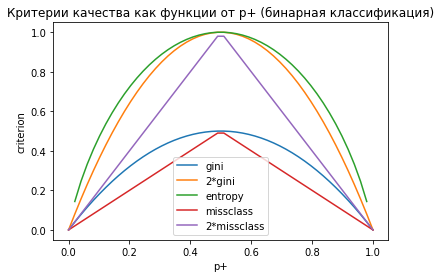

In [82]:
plt.rcParams['figure.figsize'] = (6,4)
xx = np.linspace(0,1,50)
plt.plot(xx, [2 * x * (1-x) for x in xx], label='gini')
plt.plot(xx, [4 * x * (1-x) for x in xx], label='2*gini')
plt.plot(xx, [-x * np.log2(x) - (1-x) * np.log2(1 - x)  for x in xx], label='entropy')
plt.plot(xx, [1 - max(x, 1-x) for x in xx], label='missclass')
plt.plot(xx, [2 - 2 * max(x, 1-x) for x in xx], label='2*missclass')
plt.xlabel('p+')
plt.ylabel('criterion')
plt.title('Критерии качества как функции от p+ (бинарная классификация)')
plt.legend();

Пример
Рассмотрим пример применения дерева решений из библиотеки Scikit-learn для синтетических данных. Сгенерируем данные. Два класса будут сгенерированы из двух нормальных распределений с разными средними.

In [83]:
# первый класс
np.seed = 7
train_data = np.random.normal(size=(100, 2))
train_labels = np.zeros(100)

# добавляем второй класс
train_data = np.r_[train_data, np.random.normal(size=(100, 2), loc=2)]
train_labels = np.r_[train_labels, np.ones(100)]

Напишем вспомогательную функцию, которая будет возвращать решетку для дальнейшей красивой визуализации

In [84]:
def get_grid(data, eps=0.01):
    x_min, x_max = data[:, 0].min() - 1, data[:, 0].max() + 1
    y_min, y_max = data[:, 1].min() - 1, data[:, 1].max() + 1
    return np.meshgrid(np.arange(x_min, x_max, eps),
                         np.arange(y_min, y_max, eps))

Отобразим данные. Неформально, задача классификации в этом случае – построить какую-то "хорошую" границу, разделяющую 2 класса (красные точки от желтых). Если утрировать, то машинное обучение в этом случае сводится к тому, как выбрать хорошую разделяющую границу. Возможно, прямая будет слишком простой границей, а какая-то сложная кривая, огибающая каждую красную точку – будет слишком сложной и будем много ошибаться на новых примерах из того же распределения, из которого пришла обучающая выборка. Интуиция подсказывает, что хорошо на новых данных будет работать какая-то гладкая граница, разделяющая 2 класса, или хотя бы просто прямая (в $n$-мерном случае - гиперплоскость).

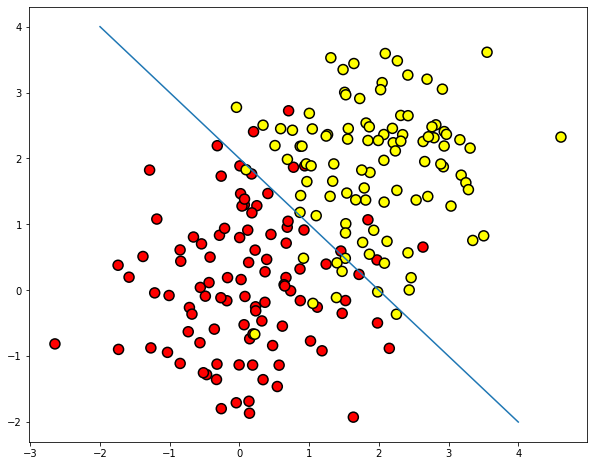

In [85]:
plt.rcParams['figure.figsize'] = (10,8)
plt.scatter(train_data[:, 0], train_data[:, 1], c=train_labels, s=100, 
            cmap='autumn', edgecolors='black', linewidth=1.5)
plt.plot(range(-2,5), range(4,-3,-1));


Попробуем разделить эти два класса, обучив дерево решений. В дереве будем использовать параметр max_depth, ограничивающий глубину дерева. Визуализируем полученную границу разделения класссов.

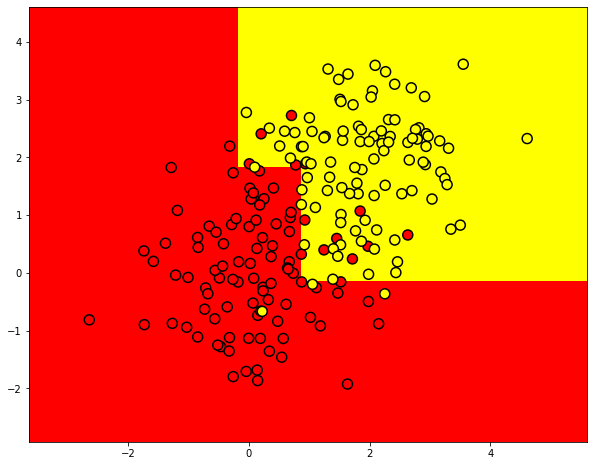

In [86]:
from sklearn.tree import DecisionTreeClassifier

# параметр min_samples_leaf указывает, при каком минимальном количестве
# элементов в узле он будет дальше разделяться
clf_tree = DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=17)

# обучаем дерево
clf_tree.fit(train_data, train_labels)

# немного кода для отображения разделяющей поверхности
xx, yy = get_grid(train_data)
predicted = clf_tree.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
plt.pcolormesh(xx, yy, predicted, cmap='autumn')
plt.scatter(train_data[:, 0], train_data[:, 1], c=train_labels, s=100, 
            cmap='autumn', edgecolors='black', linewidth=1.5);

<h1><b>Как дерево решений работает с количественными признаками</b></h1>

Допустим, в выборке имеется количественный признак "Возраст", имеющий много уникальных значений. Дерево решений будет искать лучшее (по критерию типа прироста информации) разбиение выборки, проверяя бинарные признаки типа "Возраст < 17", "Возраст < 22.87" и т.д. Но что если таких "нарезаний" возраста слишком много? А что если есть еще количественный признак "Зарплата", и зарплату тоже можно "нарезать" большим числом способов? Получается слишком много бинарных признаков для выбора лучшего на каждом шаге построения дерева. Для решения этой проблемы применяют эвристики для ограничения числа порогов, с которыми мы сравниваем количественный признак.

Рассмотрим это на игрушечном примере. Пусть есть следующая выборка:

In [87]:
data = pd.DataFrame({'Возраст': [17,64,18,20,38,49,55,25,29,31,33], 
             'Невозврат кредита': [1,0,1,0,1,0,0,1,1,0,1]})

In [88]:
data

,Возраст,Невозврат кредита
0,17,1
1,64,0
2,18,1
3,20,0
4,38,1
5,49,0
6,55,0
7,25,1
8,29,1
9,31,0


In [89]:

data.sort_values('Возраст')

,Возраст,Невозврат кредита
0,17,1
2,18,1
3,20,0
7,25,1
8,29,1
9,31,0
10,33,1
4,38,1
5,49,0
6,55,0


Обучим на этих данных дерево решений (без ограничения глубины) и посмотрим на него.

In [90]:
age_tree = DecisionTreeClassifier(random_state=17)
age_tree.fit(data['Возраст'].values.reshape(-1, 1), data['Невозврат кредита'].values)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=17, splitter='best')

In [91]:
! pip install pydot

Видим, что дерево задействовало 5 значений, с которыми сравнивается возраст: 43.5, 19, 22.5, 30 и 32 года. Если приглядеться, то это аккурат средние значения между возрастами, при которых целевой класс "меняется" с 1 на 0 или наоборот. Сложная фраза, поэтому пример: 43.5 – это среднее между 38 и 49 годами, клиент, которому 38 лет не вернул кредит, а тот, которому 49 – вернул. Аналогично, 19 лет – среднее между 18 и 20 годами. То есть в качестве порогов для "нарезания" количественного признака, дерево "смотрит" на те значения, при которых целевой класс меняет свое значение.



In [92]:
data.columns

Index(['Возраст', 'Невозврат кредита'], dtype='object')

In [93]:
from IPython.display import Image
from sklearn.tree import export_graphviz
from subprocess import call

export_graphviz(age_tree,
                out_file='tree.dot',
                # задать названия фич
                # feature_names=X.columns,
                class_names=None,
                # показывать названия полей у численных значений внутри узла
                feature_names=['Возраст'],
                label='all',
                # раскрашивать узлы в цвет преобладающего класса
                filled=True,
                # показывать значение impurity для каждого узла
                impurity=True,
                # показывать номера узлов
                node_ids=True,
                # Показывать доли каждого класса в узлах (а не количество)
                proportion=True,
                # Повернуть дерево на 90 градусов (вертикальная ориентация)
                rotate=False,
                # Число точек после запятой для отображаемых дробей
                # precision=3
               )
!dot -Tpng tree.dot -o tree.png


In [94]:
!dot -Tpng tree.dot -o tree.png

In [95]:
#pip install graphviz

In [96]:
#conda install graphviz

In [97]:
#conda install python-graphviz

In [98]:
import pydot

(graph,) = pydot.graph_from_dot_file('tree.dot')
graph.write_png('tree.png')

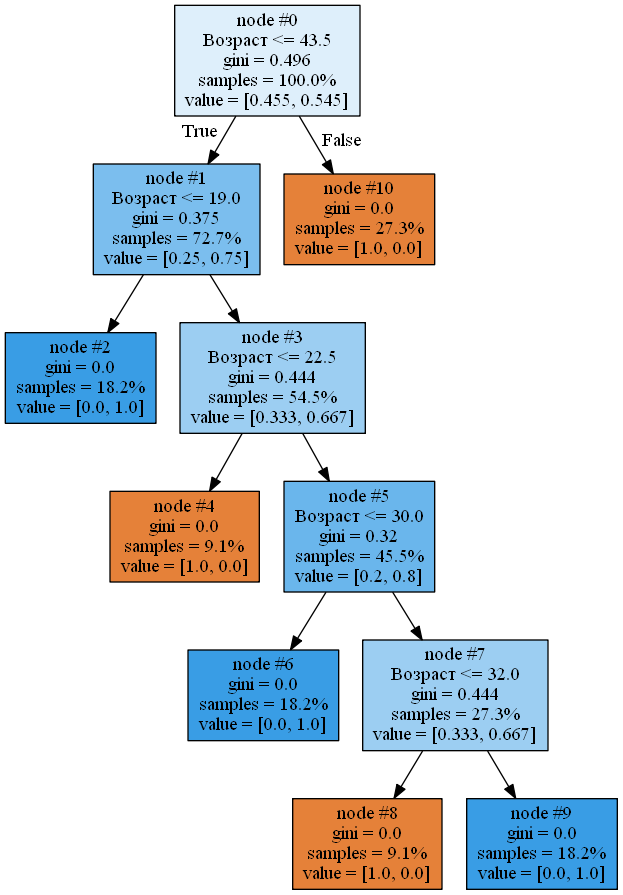

In [99]:
Image("tree.png")

Видим, что дерево задействовало 5 значений, с которыми сравнивается возраст: 43.5, 19, 22.5, 30 и 32 года. Если приглядеться, то это аккурат средние значения между возрастами, при которых целевой класс "меняется" с 1 на 0 или наоборот. Сложная фраза, поэтому пример: 43.5 – это среднее между 38 и 49 годами, клиент, которому 38 лет не вернул кредит, а тот, которому 49 – вернул. Аналогично, 19 лет – среднее между 18 и 20 годами. То есть в качестве порогов для "нарезания" количественного признака, дерево "смотрит" на те значения, при которых целевой класс меняет свое значение.

Подумайте, почему не имеет смысла в данном случае рассматривать признак "Возраст < 17.5".

Рассмотрим пример посложнее: добавим признак "Зарплата" (тыс. рублей/месяц).

In [100]:
data2 = pd.DataFrame({'Возраст':  [17,64,18,20,38,49,55,25,29,31,33], 
                      'Зарплата': [25,80,22,36,37,59,74,70,33,102,88], 
             'Невозврат кредита': [1,0,1,0,1,0,0,1,1,0,1]})

In [101]:
data2

,Возраст,Зарплата,Невозврат кредита
0,17,25,1
1,64,80,0
2,18,22,1
3,20,36,0
4,38,37,1
5,49,59,0
6,55,74,0
7,25,70,1
8,29,33,1
9,31,102,0


Если отсортировать по возрасту, то целевой класс ("Невозврат кредита") меняется (с 1 на 0 или наоборот) 5 раз. А если отсортировать по зарплате – то 7 раз. Как теперь дерево будет выбирать признаки? Посмотрим.

In [102]:
data2.sort_values('Возраст')

,Возраст,Зарплата,Невозврат кредита
0,17,25,1
2,18,22,1
3,20,36,0
7,25,70,1
8,29,33,1
9,31,102,0
10,33,88,1
4,38,37,1
5,49,59,0
6,55,74,0


In [103]:
data2.sort_values('Зарплата')

,Возраст,Зарплата,Невозврат кредита
2,18,22,1
0,17,25,1
8,29,33,1
3,20,36,0
4,38,37,1
5,49,59,0
7,25,70,1
6,55,74,0
1,64,80,0
10,33,88,1


In [104]:
age_sal_tree = DecisionTreeClassifier(random_state=17)
age_sal_tree.fit(data2[['Возраст', 'Зарплата']].values, data2['Невозврат кредита'].values);

In [105]:
from IPython.display import Image
from sklearn.tree import export_graphviz
from subprocess import call

export_graphviz(age_sal_tree,
                out_file='tree2.dot',
                # задать названия фич
                # feature_names=X.columns,
                class_names=None,
                # показывать названия полей у численных значений внутри узла
                feature_names=data2[['Возраст', 'Зарплата']].columns,
                label='all',
                # раскрашивать узлы в цвет преобладающего класса
                filled=True,
                # показывать значение impurity для каждого узла
                impurity=True,
                # показывать номера узлов
                node_ids=True,
                # Показывать доли каждого класса в узлах (а не количество)
                proportion=True,
                # Повернуть дерево на 90 градусов (вертикальная ориентация)
                rotate=False,
                # Число точек после запятой для отображаемых дробей
                # precision=3
               )
!dot -Tpng tree2.dot -o tree2.png

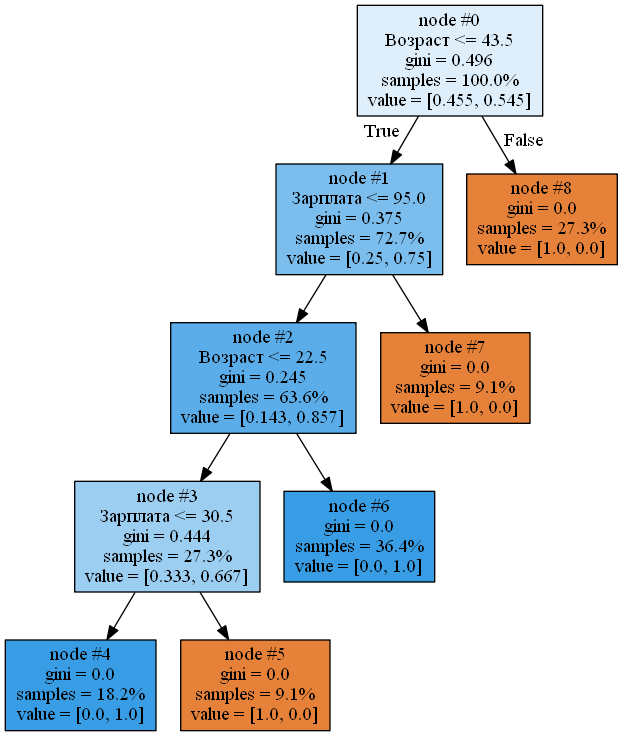

In [106]:
Image("tree2.png")

Видим, что в дереве задействованы как разбиения по возрасту, так и по зарплате. Причем пороги, с которыми сравниваются признаки: 43.5 и 22.5 года – для возраста и 95 и 30.5 тыс. руб/мес – для зарплаты. И опять можно заметить, что 95 тыс. – это среднее между 88 и 102, при этом человек с зарплатой 88 оказался "плохим", а с 102 – "хорошим". То же самое для 30.5 тыс. То есть перебирались сравнения зарплаты и возраста не со всеми возможными значениями, а только с несколькими. А почему в дереве оказались именно эти признаки? Потому что по ним разбиения оказались лучше (по критерию неопределенности Джини).

<h1><b>Вывод: самая простая эвристика для обработки количественных признаков в дереве решений: количественный признак сортируется по возрастанию, и в дереве проверяются только те пороги, при которых целевой признак меняет значение.</b></h1>

<h1>Дерево решений в задаче регрессии</h1>

При прогнозировании количественного признака идея построения дерева остается та же, но меняется критерий качества:


Дисперсия вокруг среднего: 
где  – число объектов в листе,  – значения целевого признака. Попросту говоря, минимизируя дисперсию вокруг среднего, мы ищем признаки, разбивающие выборку таким образом, что значения целевого признака в каждом листе примерно равны.


In [107]:
n_train = 150        
n_test = 1000       
noise = 0.1


def f(x):
    x = x.ravel()

    return np.exp(-x ** 2) + 1.5 * np.exp(-(x - 2) ** 2)

def generate(n_samples, noise):
    X = np.random.rand(n_samples) * 10 - 5
    X = np.sort(X).ravel()
    y = np.exp(-X ** 2) + 1.5 * np.exp(-(X - 2) ** 2) + \
        np.random.normal(0.0, noise, n_samples)
    X = X.reshape((n_samples, 1))

    return X, y

X_train, y_train = generate(n_samples=n_train, noise=noise)
X_test, y_test = generate(n_samples=n_test, noise=noise)

In [108]:
from sklearn.tree import DecisionTreeRegressor
     
reg_tree = DecisionTreeRegressor(max_depth=5, random_state=17)

reg_tree.fit(X_train, y_train)
reg_tree_pred = reg_tree.predict(X_test)

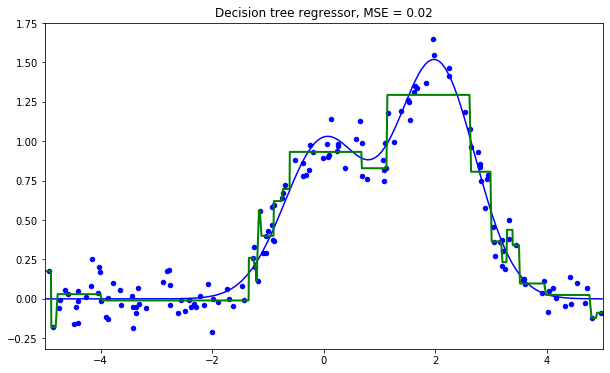

In [109]:
plt.figure(figsize=(10, 6))
plt.plot(X_test, f(X_test), "b")
plt.scatter(X_train, y_train, c="b", s=20)
plt.plot(X_test, reg_tree_pred, "g", lw=2)
plt.xlim([-5, 5])
plt.title("Decision tree regressor, MSE = %.2f" % (np.sum((y_test - reg_tree_pred) ** 2) / n_test))
plt.show()

Видим, что дерево решений аппроксимирует зависимость в данных кусочно-постоянной функцией

<h1>Деревья решений и метод ближайших соседей в задаче прогнозирования оттока клиентов телеком-оператора</h1>
¶
Считаем данные в DataFrame и проведем предобработку. Штаты пока сохраним в отдельный объект Series, но удалим из датафрейма. Первую модель будем обучать без штатов, потом посмотрим, помогают ли они.

In [110]:
df = pd.read_csv('telecom_churn.csv')

In [111]:
df

,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,...,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3328,AZ,192,415,414-4276,no,yes,36,156.2,77,26.55,...,126,18.32,279.1,83,12.56,9.9,6,2.67,2,False
3329,WV,68,415,370-3271,no,no,0,231.1,57,39.29,...,55,13.04,191.3,123,8.61,9.6,4,2.59,3,False
3330,RI,28,510,328-8230,no,no,0,180.8,109,30.74,...,58,24.55,191.9,91,8.64,14.1,6,3.81,2,False
3331,CT,184,510,364-6381,yes,no,0,213.8,105,36.35,...,84,13.57,139.2,137,6.26,5.0,10,1.35,2,False


In [112]:
df.drop(['state', 'phone number'], axis=1, inplace = True)

In [113]:
df['international plan'] = df['international plan'].map(lambda x: int(x=='yes'))
df['voice mail plan'] = df['voice mail plan'].map(lambda x: int(x=='yes'))

In [114]:
df

,account length,area code,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
0,128,415,0,1,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,107,415,0,1,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,137,415,0,0,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,84,408,1,0,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,75,415,1,0,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3328,192,415,0,1,36,156.2,77,26.55,215.5,126,18.32,279.1,83,12.56,9.9,6,2.67,2,False
3329,68,415,0,0,0,231.1,57,39.29,153.4,55,13.04,191.3,123,8.61,9.6,4,2.59,3,False
3330,28,510,0,0,0,180.8,109,30.74,288.8,58,24.55,191.9,91,8.64,14.1,6,3.81,2,False
3331,184,510,1,0,0,213.8,105,36.35,159.6,84,13.57,139.2,137,6.26,5.0,10,1.35,2,False


In [115]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 19 columns):
account length            3333 non-null int64
area code                 3333 non-null int64
international plan        3333 non-null int64
voice mail plan           3333 non-null int64
number vmail messages     3333 non-null int64
total day minutes         3333 non-null float64
total day calls           3333 non-null int64
total day charge          3333 non-null float64
total eve minutes         3333 non-null float64
total eve calls           3333 non-null int64
total eve charge          3333 non-null float64
total night minutes       3333 non-null float64
total night calls         3333 non-null int64
total night charge        3333 non-null float64
total intl minutes        3333 non-null float64
total intl calls          3333 non-null int64
total intl charge         3333 non-null float64
customer service calls    3333 non-null int64
churn                     3333 non-null bool
dtyp

In [116]:
y = df['churn'].astype('int')

In [117]:
X = df.drop('churn', axis=1)

In [118]:
X.shape, y.shape

((3333, 18), (3333,))

In [119]:
from sklearn.model_selection import train_test_split, StratifiedKFold

Выделим 70% выборки (X_train, y_train) под обучение и 30% будут отложенной выборкой (X_holdout, y_holdout). отложенная выборка никак не будет участвовать в настройке параметров моделей, на ней мы в конце, после этой настройки, оценим качество полученной модели

In [120]:
X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, test_size=0.3,
                                                          random_state=228)

In [121]:
X_train.shape, X_holdout.shape

((2333, 18), (1000, 18))

Обучим 2 модели – дерево решений и kNN, пока не знаем, какие параметры хороши, поэтому наугад: глубину дерева берем 5, число ближайших соседей – 10

In [122]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(max_depth=5, random_state=17)
knn = KNeighborsClassifier(n_neighbors=10)

In [123]:
%%time
tree.fit(X_train, y_train)

Wall time: 11 ms


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=17, splitter='best')

In [124]:
tree.get_params

<bound method BaseEstimator.get_params of DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=17, splitter='best')>

In [125]:
%%time
knn.fit(X_train, y_train)

Wall time: 3.99 ms


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=10, p=2,
                     weights='uniform')

Качество прогнозов будем проверять с помощью простой метрики – доли правильных ответов

In [126]:
from sklearn.metrics import accuracy_score

In [127]:
tree_pred = tree.predict(X_holdout)
accuracy_score(y_holdout, tree_pred)

0.931

In [128]:
knn_pred = knn.predict(X_holdout)
accuracy_score(y_holdout, knn_pred)


0.856

Теперь настроим параметры дерева на кросс-валидации. Настраивать будем максимальную глубину и максимальное используемое на каждом разбиении число признаков. Суть того, как работает GridSearchCV: для каждой уникальной пары значений параметров max_depth и max_features будет проведена 5-кратная кросс-валидация и выберется лучшее сочетание параметров.

In [129]:
from sklearn.model_selection import GridSearchCV, cross_val_score

In [130]:
tree_params = {'max_depth': range(1,11),
               'max_features': range(4,19)}
               

In [131]:
tree_grid = GridSearchCV(tree, tree_params,
                         cv=5, n_jobs=-1,
                        verbose=True)

In [132]:
tree_grid.fit(X_train, y_train) 

Fitting 5 folds for each of 150 candidates, totalling 750 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 175 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 750 out of 750 | elapsed:    4.1s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=5,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=17,
                                              splitter='best'),
             iid='warn', n_jobs=-1,
             param_grid={'max_depth': range(1, 11),
                         'max_features': range(4, 19)},
             pre_dispatch='2*n_jobs

Лучшее сочетание параметров и соответствующая средняя доля правильных ответов на кросс-валидации:

In [133]:
tree_grid.best_params_ #- Ответ: 'max_depth': 9, 'max_features': 14

{'max_depth': 9, 'max_features': 14}

In [134]:
tree_grid.best_score_   

0.9429918559794256

In [135]:

accuracy_score(y_holdout, tree_grid.predict(X_holdout)) 

0.917

In [140]:
tree_model=DecisionTreeClassifier(max_depth=9, random_state=14).fit(X_train, y_train) 
export_graphviz(tree_model,
                out_file='tree3.dot',
                # задать названия фич
                feature_names=X.columns,
                class_names=None,
                # показывать названия полей у численных значений внутри узла
                #feature_names=data2[['Возраст', 'Зарплата']].columns,
                label='all',
                # раскрашивать узлы в цвет преобладающего класса
                filled=True,
                # показывать значение impurity для каждого узла
                impurity=True,
                # показывать номера узлов
                node_ids=True,
                # Показывать доли каждого класса в узлах (а не количество)
                proportion=True,
                # Повернуть дерево на 90 градусов (вертикальная ориентация)
                rotate=False,
                # Число точек после запятой для отображаемых дробей
                # precision=3
               )
!dot -Tpng tree3.dot -o tree3.png

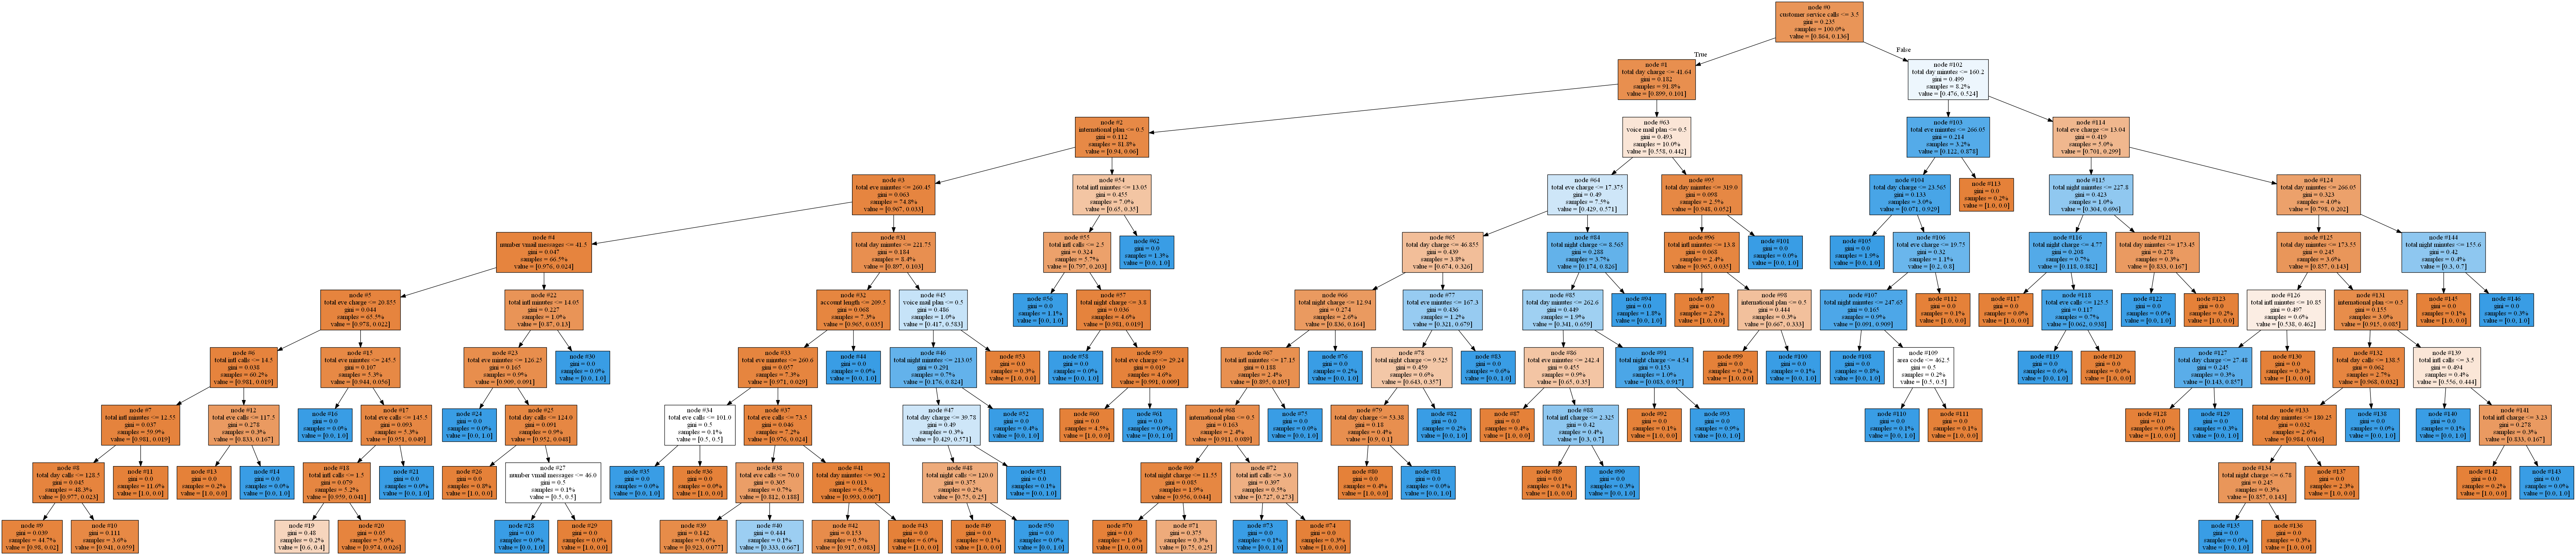

In [141]:
Image("tree3.png")

In [142]:

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [143]:
knn_pipe = Pipeline([('scaler', StandardScaler()), ('knn', KNeighborsClassifier(n_jobs=-1))])

In [144]:
knn_params = {'knn__n_neighbors': range(1, 10)}

In [145]:
knn_grid = GridSearchCV(knn_pipe, knn_params,
                         cv=5, n_jobs=-1,
                        verbose=True)

In [146]:
knn_grid.fit(X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    3.0s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('scaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('knn',
                                        KNeighborsClassifier(algorithm='auto',
                                                             leaf_size=30,
                                                             metric='minkowski',
                                                             metric_params=None,
                                                             n_jobs=-1,
                                                             n_neighbors=5, p=2,
                                                             weights='uniform'))],
                                verbose=False

In [147]:
knn_grid.best_params_, knn_grid.best_score_

({'knn__n_neighbors': 9}, 0.8954136305186455)

In [148]:
accuracy_score(y_holdout, knn_grid.predict(X_holdout))


0.862

<h1>Деревья решений и метод ближайших соседей в задаче распознавания рукописных цифр MNIST</h1>
¶
Теперь посмотрим на описанные 2 алгоритма в реальной задаче. Используемый "встроенные" в sklearn данные по рукописным цифрам. Эта задача будет примером, когда метод ближайших соседей работает на удивление хорошо.

In [149]:
from sklearn.datasets import load_digits

In [150]:
data = load_digits()
X, y = data.data, data.target

In [151]:
X[0,:].reshape([8,8])

array([[ 0.,  0.,  5., 13.,  9.,  1.,  0.,  0.],
       [ 0.,  0., 13., 15., 10., 15.,  5.,  0.],
       [ 0.,  3., 15.,  2.,  0., 11.,  8.,  0.],
       [ 0.,  4., 12.,  0.,  0.,  8.,  8.,  0.],
       [ 0.,  5.,  8.,  0.,  0.,  9.,  8.,  0.],
       [ 0.,  4., 11.,  0.,  1., 12.,  7.,  0.],
       [ 0.,  2., 14.,  5., 10., 12.,  0.,  0.],
       [ 0.,  0.,  6., 13., 10.,  0.,  0.,  0.]])

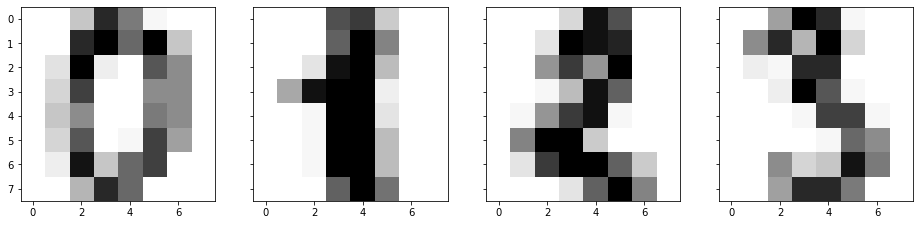

In [152]:
f, axes = plt.subplots(1, 4, sharey=True, figsize=(16,6))
for i in range(4):    
    axes[i].imshow(X[i,:].reshape([8,8]), cmap='Greys');

In [153]:
X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, test_size=0.3,
                                                          random_state=17)

In [154]:
tree = DecisionTreeClassifier(max_depth=5, random_state=17)
knn = KNeighborsClassifier(n_neighbors=10)

In [155]:
%%time
tree.fit(X_train, y_train)

Wall time: 8.98 ms


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=17, splitter='best')

In [156]:
%%time
knn.fit(X_train, y_train)

Wall time: 2.99 ms


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=10, p=2,
                     weights='uniform')

Сделаем прогнозы для отложенной выборки. Видим, что метод ближайших соседей справился намного лучше. Но это мы пока выбирали параметры наугад.

In [157]:
tree_pred = tree.predict(X_holdout)
knn_pred = knn.predict(X_holdout)
accuracy_score(y_holdout, knn_pred), accuracy_score(y_holdout, tree_pred)

(0.9740740740740741, 0.6666666666666666)

In [158]:
tree_params = {'max_depth': [1, 2, 3, 5, 10, 20, 25, 30, 40, 50, 64],
               'max_features': [1, 2, 3, 5, 10, 20 ,30, 50, 64]}

In [159]:
tree_grid = GridSearchCV(tree, tree_params,
                         cv=5, n_jobs=-1,
                        verbose=True)

In [160]:
tree_grid.fit(X_train, y_train)

Fitting 5 folds for each of 99 candidates, totalling 495 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 495 out of 495 | elapsed:    0.8s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=5,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=17,
                                              splitter='best'),
             iid='warn', n_jobs=-1,
             param_grid={'max_depth': [1, 2, 3, 5, 10, 20, 25, 30, 40, 50, 64],
                         'max_features': [1, 2, 3, 5, 10, 20, 3

Лучшее сочетание параметров и соответствующая средняя доля правильных ответов на кросс-валидации:

In [161]:
tree_grid.best_params_, tree_grid.best_score_

({'max_depth': 20, 'max_features': 64}, 0.8440731901352426)

In [162]:
accuracy_score(y_holdout, tree_grid.predict(X_holdout))

0.8388888888888889

In [163]:
(cross_val_score(KNeighborsClassifier(n_neighbors=1), X_train, y_train, cv=5))

array([0.96875   , 0.99212598, 0.99206349, 0.99193548, 0.98785425])

In [164]:
np.mean(cross_val_score(KNeighborsClassifier(n_neighbors=1), X_train, y_train, cv=5))

0.9865458422397149

In [165]:
knn = KNeighborsClassifier(n_neighbors=1).fit(X_train, y_train)
accuracy_score(y_holdout, knn.predict(X_holdout))

0.9833333333333333

# Проведем анализ WINE.TXT

In [166]:
df = pd.read_csv('Wine.txt',sep="\t")
df

,Input1,Input2,Input3,Input4,Input5,Input6,Input7,Input8,Input9,Input10,Input11,Input12,Input13,Desired1(3)
0,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065,0
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050,0
2,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185,0
3,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480,0
4,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,13.71,5.65,2.45,20.5,95,1.68,0.61,0.52,1.06,7.70,0.64,1.74,740,1
174,13.40,3.91,2.48,23.0,102,1.80,0.75,0.43,1.41,7.30,0.70,1.56,750,1
175,13.27,4.28,2.26,20.0,120,1.59,0.69,0.43,1.35,10.20,0.59,1.56,835,1
176,13.17,2.59,2.37,20.0,120,1.65,0.68,0.53,1.46,9.30,0.60,1.62,840,1


In [167]:
y = df['Desired1(3)'].astype('int')
X = df.drop('Desired1(3)', axis=1)

In [168]:

X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, test_size=0.3,
                                                          random_state=17)

In [169]:
tree = DecisionTreeClassifier(max_depth=5, random_state=17)
knn = KNeighborsClassifier(n_neighbors=10)

In [170]:
%%time
tree.fit(X_train, y_train)

Wall time: 1.99 ms


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=17, splitter='best')

In [171]:
%%time
knn.fit(X_train, y_train)

Wall time: 997 µs


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=10, p=2,
                     weights='uniform')

In [172]:
tree_pred = tree.predict(X_holdout)
accuracy_score(y_holdout, tree_pred)

0.9444444444444444

In [173]:
knn_pred = knn.predict(X_holdout)
accuracy_score(y_holdout, knn_pred)


0.6666666666666666

In [174]:
tree_params = {'max_depth': range(1,11),
               'max_features': range(4,13)}
               

In [175]:
tree_grid = GridSearchCV(tree, tree_params,
                         cv=5, n_jobs=-1,
                        verbose=True)

In [176]:
tree_grid.fit(X_train, y_train) 

Fitting 5 folds for each of 90 candidates, totalling 450 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 450 out of 450 | elapsed:    0.6s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=5,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=17,
                                              splitter='best'),
             iid='warn', n_jobs=-1,
             param_grid={'max_depth': range(1, 11),
                         'max_features': range(4, 13)},
             pre_dispatch='2*n_jobs

In [177]:
tree_grid.best_params_ 


{'max_depth': 4, 'max_features': 4}

In [178]:
tree_grid.best_score_

0.9354838709677419

In [179]:
accuracy_score(y_holdout, tree_grid.predict(X_holdout))

0.9259259259259259

In [188]:
tree_model=DecisionTreeClassifier(max_depth=4, max_features=4, random_state=14).fit(X_train, y_train) 
export_graphviz(tree_model,
                out_file='tree4.dot',
                # задать названия фич
                #feature_names=X.columns,
                class_names=None,
                # показывать названия полей у численных значений внутри узла
                #feature_names=data2[['Возраст', 'Зарплата']].columns,
                label='all',
                # раскрашивать узлы в цвет преобладающего класса
                filled=True,
                # показывать значение impurity для каждого узла
                impurity=True,
                # показывать номера узлов
                node_ids=True,
                # Показывать доли каждого класса в узлах (а не количество)
                proportion=True,
                # Повернуть дерево на 90 градусов (вертикальная ориентация)
                rotate=False,
                # Число точек после запятой для отображаемых дробей
                # precision=3
               )
!dot -Tpng tree4.dot -o tree4.png

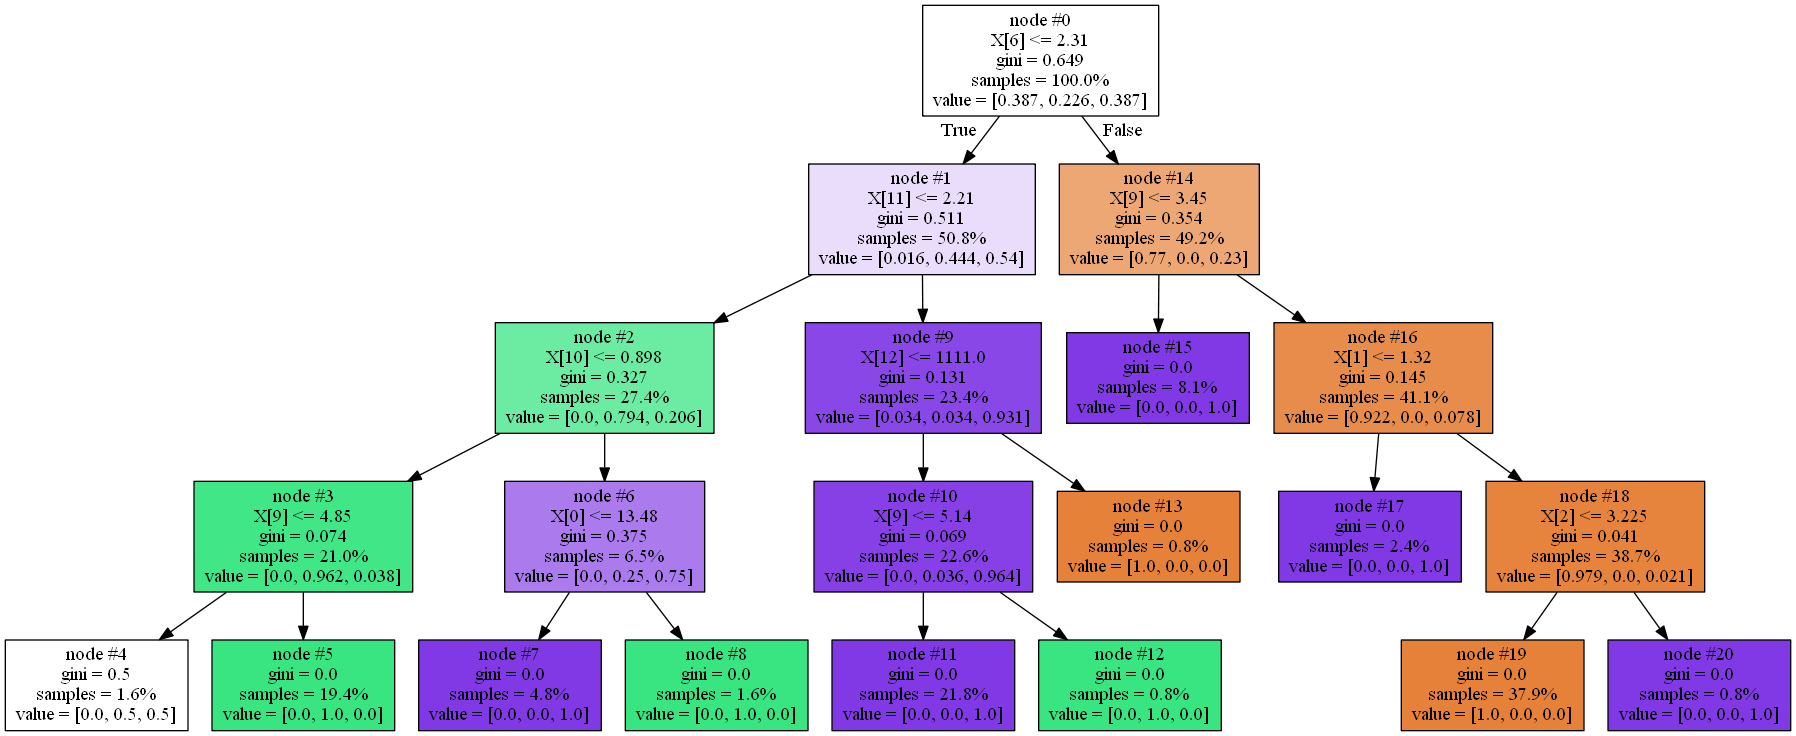

In [189]:
Image("tree4.png")

In [180]:
knn_pipe = Pipeline([('scaler', StandardScaler()), ('knn', KNeighborsClassifier(n_jobs=-1))])

In [181]:
knn_params = {'knn__n_neighbors': range(1, 10)}
knn_grid = GridSearchCV(knn_pipe, knn_params,
                         cv=5, n_jobs=-1,
                        verbose=True)

In [182]:
knn_grid.fit(X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 out of  45 | elapsed:    1.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.3s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('scaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('knn',
                                        KNeighborsClassifier(algorithm='auto',
                                                             leaf_size=30,
                                                             metric='minkowski',
                                                             metric_params=None,
                                                             n_jobs=-1,
                                                             n_neighbors=5, p=2,
                                                             weights='uniform'))],
                                verbose=False

In [183]:
knn_grid.best_params_

({'knn__n_neighbors': 3},)

In [184]:
knn_grid.best_score_

0.9516129032258065

In [185]:
accuracy_score(y_holdout, knn_grid.predict(X_holdout))

0.9814814814814815

# Проведем анализ Credit.csv

In [190]:
df = pd.read_csv('Credit.csv',sep=";",encoding='cp1251')

In [191]:
df

,кредит,клаcс,з_плата,возраст,кр_карта
0,1,2,2,2,1
1,0,2,1,2,0
2,0,4,1,1,1
3,1,2,2,2,0
4,1,3,2,1,0
...,...,...,...,...,...
318,1,2,2,3,0
319,1,2,1,1,0
320,1,2,2,2,0
321,1,2,2,3,0


In [192]:
y = df['кредит'].astype('int')
X = df.drop('кредит', axis=1)

In [193]:
X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, test_size=0.3,
                                                          random_state=17)

In [194]:
tree = DecisionTreeClassifier(max_depth=5, random_state=17)
knn = KNeighborsClassifier(n_neighbors=10)

In [195]:
%%time
tree.fit(X_train, y_train)

Wall time: 1.96 ms


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=17, splitter='best')

In [196]:
%%time
knn.fit(X_train, y_train)

Wall time: 1.98 ms


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=10, p=2,
                     weights='uniform')

In [197]:
tree_pred = tree.predict(X_holdout)
accuracy_score(y_holdout, tree_pred)

0.8762886597938144

In [198]:
knn_pred = knn.predict(X_holdout)
accuracy_score(y_holdout, knn_pred)


0.8762886597938144

In [199]:
tree_params = {'max_depth': range(1,11),
               'max_features': range(1,4)}

In [200]:
tree_grid = GridSearchCV(tree, tree_params,
                         cv=5, n_jobs=-1,
                        verbose=True)

In [201]:
tree_grid.fit(X_train, y_train) 

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    2.2s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=5,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=17,
                                              splitter='best'),
             iid='warn', n_jobs=-1,
             param_grid={'max_depth': range(1, 11),
                         'max_features': range(1, 4)},
             pre_dispatch='2*n_jobs'

In [202]:
tree_grid.best_params_ 

{'max_depth': 1, 'max_features': 3}

In [203]:
tree_grid.best_score_

0.8672566371681416

In [204]:
accuracy_score(y_holdout, tree_grid.predict(X_holdout))

0.8247422680412371

In [205]:
tree_model=DecisionTreeClassifier(max_depth=4, max_features=4, random_state=14).fit(X_train, y_train) 
export_graphviz(tree_model,
                out_file='tree5.dot',
                # задать названия фич
                feature_names=X.columns,
                class_names=None,
                # показывать названия полей у численных значений внутри узла
                #feature_names=data2[['Возраст', 'Зарплата']].columns,
                label='all',
                # раскрашивать узлы в цвет преобладающего класса
                filled=True,
                # показывать значение impurity для каждого узла
                impurity=True,
                # показывать номера узлов
                node_ids=True,
                # Показывать доли каждого класса в узлах (а не количество)
                proportion=True,
                # Повернуть дерево на 90 градусов (вертикальная ориентация)
                rotate=False,
                # Число точек после запятой для отображаемых дробей
                # precision=3
               )
!dot -Tpng tree5.dot -o tree5.png

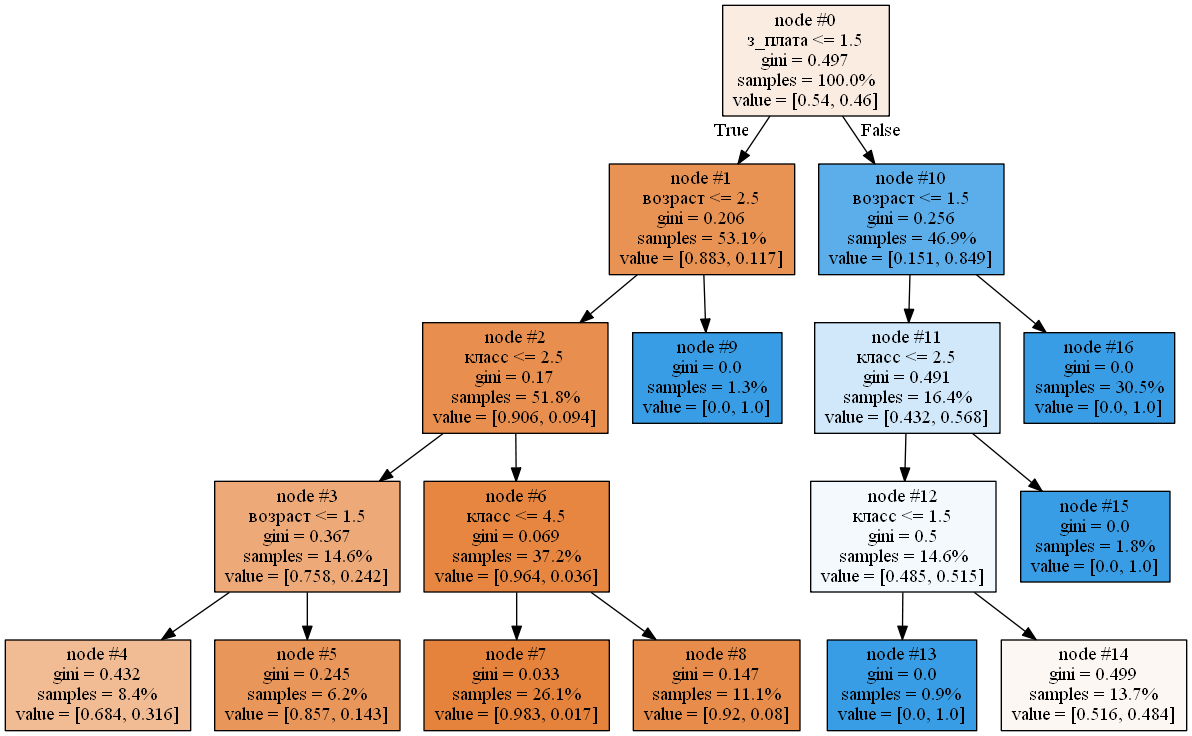

In [206]:
Image("tree5.png")

In [207]:
knn_pipe = Pipeline([('scaler', StandardScaler()), ('knn', KNeighborsClassifier(n_jobs=-1))])

In [208]:
knn_params = {'knn__n_neighbors': range(1, 10)}

In [209]:
knn_grid = GridSearchCV(knn_pipe, knn_params,
                         cv=5, n_jobs=-1,
                        verbose=True)

In [210]:
knn_grid.fit(X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 out of  45 | elapsed:    1.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.3s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('scaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('knn',
                                        KNeighborsClassifier(algorithm='auto',
                                                             leaf_size=30,
                                                             metric='minkowski',
                                                             metric_params=None,
                                                             n_jobs=-1,
                                                             n_neighbors=5, p=2,
                                                             weights='uniform'))],
                                verbose=False

In [211]:
knn_grid.best_params_,
knn_grid.best_score_

0.8628318584070797

In [212]:
accuracy_score(y_holdout, knn_grid.predict(X_holdout))

0.8144329896907216

<h1>Вывод по этому эксперименту (и общий совет): в начале проверяйте на своих данных простые модели – дерево решений и метод ближайших соседей (а в следующий раз сюда добавится логистическая регрессия), может оказаться, что уже они работают достаточно хорошо